# Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import phyaat

In [12]:
#!pip install phyaat  # if not installed yet

import phyaat
print('Version :' ,phyaat.__version__)
import phyaat as ph

Version : 0.0.3


# Download Data - (According to the need)

In [10]:
dirPath = ph.download_data(baseDir='../PhyAAt_Data', subject=1,verbose=0,overwrite=False)
#returns a dictionary containing file names of all the subjects available in baseDir
SubID = ph.ReadFilesPath(dirPath)

NOTE:: Path :  "../PhyAAt_Data" is not accessible. Creating  "phyaat" in  "/tmp" directory for dataset
Total Subjects :  1


{1: {'sigFile': '/tmp/phyaat/phyaat_dataset/Signals/S1/S1_Signals.csv',
  'txtFile': '/tmp/phyaat/phyaat_dataset/Signals/S1/S1_Textscore.csv'}}

# Locate the subject’s file

In [3]:
#check files of subject=1
SubID[1]

{'sigFile': '/tmp/phyaat/phyaat_dataset/Signals/S1/S1_Signals.csv',
 'txtFile': '/tmp/phyaat/phyaat_dataset/Signals/S1/S1_Textscore.csv'}

# Preprocessing of Data

## Create Subj (obj) with data of Subject=1

In [8]:
# Create a Subj holding dataset of subject=1

Subj = ph.Subject(SubID[1])

## Filtering - removing DC

In [5]:
#filtering with highpass filter of cutoff frequency 0.5Hz

Subj.filter_EEG(band =[0.5],btype='highpass',order=5)

## Artifact removal using ICA [ ~6mins] 

In [9]:
#Remving Artifact using ICA, setting window size to 1280 (10sec), which is larg, but takes less time

Subj.correct(method='ICA',verbose=1,winsize=128*10)

ICA Artifact Removal : extended-infomax
99.85%|################################################# |278188\277761|


## Feature Extraction - Rhythmic Features [~2min] 

In [10]:
# setting task=-1, does extract the features from all the segmensts for all the four tasks and
# returns y_train as (n,4), one coulum for each task. Next time extracting Xy for any particular
# task won't extract the features agains, unless you force it by setting 'redo'=True.

X_train,y_train,X_test, y_test = Subj.getXy_eeg(task=-1)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

100%|##################################################|100\100|Sg - 0|    
100%|##################################################|100\100|Sg - 1|    
100%|##################################################|100\100|Sg - 2|    
100%|##################################################|43\43|Sg - 0|    
100%|##################################################|43\43|Sg - 1|    
100%|##################################################|43\43|Sg - 2|    
DataShape:  (290, 84) (290, 5) (120, 84) (120, 5)


# Predictive Modeling with SVM

In [11]:
from sklearn import svm

## T4 Task: LWR classification 

In [12]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=4)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nClass labels :',np.unique(y_train))

DataShape:  (290, 84) (290,) (120, 84) (120,)

Class labels : [0 1 2]


In [13]:
# Normalization - SVM works well with normalized features
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std


# Training
clf = svm.SVC(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

# Evaluation
T4_trac =  np.mean(y_train==ytp)
T4_tsac =  np.mean(y_test==ysp)
print('Training Accuracy:',T4_trac)
print('Testing  Accuracy:',T4_tsac)

Training Accuracy: 0.9413793103448276
Testing  Accuracy: 0.875


## T3 Task: Semanticity classification 

In [14]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=3)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nClass labels :',np.unique(y_train))

DataShape:  (100, 84) (100,) (43, 84) (43,)

Class labels : [0 1]


In [15]:
# Normalization - SVM works well with normalized features
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std


# Training
clf = svm.SVC(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)


# Evaluation
T3_trac =  np.mean(y_train==ytp)
T3_tsac =  np.mean(y_test==ysp)
print('Training Accuracy:',T3_trac)
print('Testing  Accuracy:',T3_tsac)

Training Accuracy: 0.86
Testing  Accuracy: 0.5813953488372093


## T2 Task: Noise level prediction : Regression 

In [16]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=2)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nNoise levels     :',np.unique(y_train))

#change 1000 dB to 10 dB
y_train[y_train==1000]=10
y_test[y_test==1000]=10

print('New Noise levels :',np.unique(y_train))

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
DataShape:  (100, 84) (100,) (43, 84) (43,)

Noise levels     : [  -6   -3    0    3    6 1000]
New Noise levels : [-6 -3  0  3  6 10]


In [17]:
# Normalization - SVM works well with normalized features
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std


# Training
clf = svm.SVR(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

# Evaluation
T2_tre =  np.mean(np.abs(y_train-ytp))
T2_tse =  np.mean(np.abs(y_test-ysp))
print('Training MAE:',T2_tre)
print('Testing  MAE:',T2_tse)

Training MAE: 4.002671605390758
Testing  MAE: 4.734974941124211


## T1 Task: Attention Level prediction: Regression 

In [18]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=1)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nAttention levels:\n',np.unique(y_train))

# Round off around 10

y_train = 10*(y_train//10)
y_test = 10*(y_test//10)

print('\nNew Attention levels:\n',np.unique(y_train))

If you are running feature extraction with DIFFERENT parameters again to recompute, set redo=True, else function will return pre-computed features, if exist
To suppress this warning2, set redo_warn=False
DataShape:  (100, 84) (100,) (43, 84) (43,)

Attention levels:
 [  0   7  12  14  15  18  20  22  25  28  33  37  38  42  44  45  46  50
  54  60  62  66  71  72  75  76  80  83  85  87  88 100]

New Attention levels:
 [  0  10  20  30  40  50  60  70  80 100]


In [19]:
# Normalization - SVM works well with normalized features
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std


# Training
clf = svm.SVR(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

# Evaluation
T1_tre =  np.mean(np.abs(y_train-ytp))
T1_tse =  np.mean(np.abs(y_test-ysp))
print('Training MAE:',T1_tre)
print('Testing  MAE:',T1_tse)

Training MAE: 30.32014989855741
Testing  MAE: 32.70221496347915


# Results

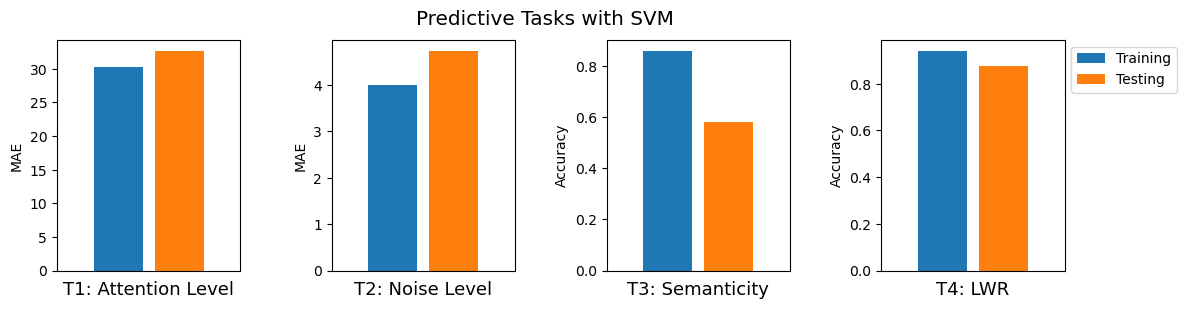

In [20]:
fig = plt.figure(figsize=(13,3))
plt.subplot(141)
plt.bar(1, [T1_tre])
plt.bar(2, [T1_tse])
plt.xlim([0,3])
plt.xticks([])
plt.xlabel('T1: Attention Level',fontsize=13)
plt.ylabel('MAE')

plt.subplot(142)
plt.bar(1, [T2_tre])
plt.bar(2, [T2_tse])
plt.xticks([])
plt.xlabel('T2: Noise Level',fontsize=13)
plt.ylabel('MAE')


plt.xlim([0,3])
plt.subplot(143)
plt.bar(1, [T3_trac])
plt.bar(2, [T3_tsac])
plt.xticks([])
plt.xlabel('T3: Semanticity',fontsize=13)
plt.ylabel('Accuracy')

plt.xlim([0,3])
plt.subplot(144)
plt.bar(1, [T4_trac],label='Training')
plt.bar(2, [T4_tsac],label='Testing')
plt.xlim([0,3])
plt.xticks([])
plt.xlabel('T4: LWR',fontsize=13)
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.5)
fig.suptitle("Predictive Tasks with SVM", fontsize="x-large")
plt.show()